In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):

    niu_data = pd.DataFrame()

    bonos = "SELECT TOP ("+ str(n) +") Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, NemotecnicoBono AS Nemotecnico, RiesgoInt FROM (SELECT * FROM (SELECT Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, Nemotecnico AS NemotecnicoBono FROM [dbAlgebra].[dbo].[TdNemoRF]) AS bono JOIN (SELECT * FROM [dbPortFolio].[dbo].[TdPlanvitalCartera]) AS planvital ON bono.FechaEmision > '20190101' AND bono.NemotecnicoBono = planvital.Nemotecnico) AS A JOIN (SELECT DISTINCT Nemotecnico, RiesgoLVA AS RiesgoInt FROM [dbAlgebra].[dbo].[TdRiesgoLva]) AS B ON A.NemotecnicoBono = B.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)

    moneda = []
    base1 = []
    base2 = []
    tabla = []
    fechaemi = []
    nemotecnico = []
    riesgo = []
    for i in range(np.size(bonos, 0)):

        if bonos["Nemotecnico"][i] in nemotecnico: continue

        if bonos["RiesgoInt"][i] in riesgo : continue

        moneda.append(bonos["Moneda"][i])
        base1.append(bonos["Base1"][i])
        base2.append(bonos["Base2"][i])
        tabla.append(bonos["TablaDesarrollo"][i])
        fechaemi.append(bonos["FechaEmision"][i])
        nemotecnico.append(bonos["Nemotecnico"][i])
        riesgo.append(bonos["RiesgoInt"][i])

    niu_data["Moneda"] = moneda
    niu_data["Base1"] = base1
    niu_data["Base2"] = base2
    niu_data["TablaDesarrollo"] = tabla
    niu_data["FechaEmision"] = fechaemi
    niu_data["Nemotecnico"] = nemotecnico
    niu_data["RiesgoInt"] = riesgo


    return niu_data

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {-1: "AAA", 1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(500,cn))
bonos

,Moneda,Base1,Base2,TablaDesarrollo,FechaEmision,Nemotecnico,RiesgoInt,Convencion,Riesgo
0,UF,ACT,365,"1#30-04-2019#0,48208#8,1616#91,8384#8,64368|2#...",2019-01-31,BSXXI-A,1,ACT/365,AAA
1,UF,ACT,365,"1#30-10-2019#1,094#0#100#1,094|2#30-04-2020#1,...",2019-04-30,BVIAS-A,3,ACT/365,AA
2,UF,ACT,365,"1#01-03-2020#0,3245#0#100#0,3245|2#01-09-2020#...",2019-09-01,BCSSA-C,2,ACT/365,AA
3,UF,ACT,365,"1#01-12-2019#0,8464#0#100#0,8464|2#01-06-2020#...",2019-06-01,BCMPC-O,-1,ACT/365,AAA
4,UF,ACT,365,"1#15-05-2020#0,7968#0#100#0,7968|2#15-11-2020#...",2019-11-15,BVOLC-A,4,ACT/365,AA
5,UF,ACT,365,"1#15-10-2019#1,7841#0#100#1,7841|2#15-04-2020#...",2019-04-15,BLATM-E,8,ACT/365,BBB


In [7]:
bonos["Riesgo"].values

array(['AAA', 'AA', 'AA', 'AAA', 'AA', 'BBB'], dtype=object)

In [8]:
derivados = derivados_dBDerivados(2, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

C:\Users\Lenovo\Documents\Universidad\Practica\Intento\Cartera\DerivadosTipos\DerivadosSCC.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_cartera.MonedaActivo[0] = "CLP"


,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [9]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.711040e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.531281e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.073699e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.194112e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.511532e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


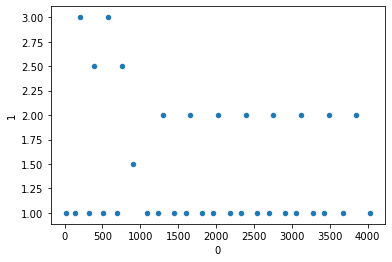

In [10]:
cartera = Cartera(acciones, bonos.head(3), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [11]:
cartera.get_diccionario_niveles()

{1: {('Renta Variable Nacional Acciones',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.51153165e+08]),
  ('Renta Variable Extranjera',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.19411228e+10, 0.00000000e+00]),
  ('Renta Fija Nacional ',
   'Bono',
   'AAA'): array([0.        , 8.99941754, 0.61790906, 0.        , 0.        ,
         0.        , 0.05532103, 7.82566741, 0.        , 1.10445764,
         5.23587948, 0.        , 0.50606577, 4.54218612, 0.        ,
         0.55334365, 3.47188001, 0.        , 0.55361428, 2.65605625,
         0.        , 0.52916067, 2.03143872, 0.        , 0.5263515 ,
         1.65552987, 0.        , 0.03507665, 0.0925565 , 0.        ,
         0.07331445, 0.21061079, 0.08124963, 0.20272877]),
  ('Renta Fija Nacional ',
   'Bono',
   'AA'): array([1.06057935e+00, 6.84798842e-01, 2.86167538e-01, 4.64649511e-01,
         1.64291687e-01, 8.5883

In [12]:
print(cartera.get_bonos()[0].get_historicos())

    UF#16#AAA  UF#138#AAA  UF#203#AAA  UF#319#AAA  UF#384#AAA  UF#498#AAA  \
0    1.002990    1.026086    1.038608    1.061335    1.074279    1.097328   
1    1.002970    1.025907    1.038342    1.060907    1.073766    1.096695   
2    1.002959    1.025809    1.038196    1.060673    1.073483    1.096335   
3    1.002978    1.025982    1.038452    1.061086    1.073983    1.096982   
4    1.002986    1.026048    1.038551    1.061243    1.074175    1.097237   
5    0.999559    0.995898    0.993715    0.989381    0.986695    0.981488   
6    0.999554    0.995485    0.992765    0.986760    0.983212    0.978300   
7    0.999556    0.995627    0.993097    0.987700    0.984536    0.979950   
8    0.999562    0.996073    0.994105    0.990397    0.988208    0.984162   
9    0.999561    0.996031    0.994013    0.990159    0.987857    0.983550   
10   0.999562    0.996106    0.994178    0.990583    0.988481    0.984635   
11   0.999561    0.996058    0.994073    0.990316    0.988088    0.983954   

In [13]:
print(cartera.get_retornos_totales())

      CLP#16#AAA  CLP#138#AAA  CLP#203#AAA  CLP#319#AAA  CLP#384#AAA  \
0   0.000000e+00     0.000000     0.000000     0.000000     0.000000   
1   7.642266e-05    -0.000078    -0.000160    -0.000306    -0.000381   
2   8.553732e-05     0.000001    -0.000044    -0.000124    -0.000167   
3   3.096009e-04     0.000458     0.000537     0.000679     0.000756   
4   1.040226e-04     0.000161     0.000191     0.000245     0.000276   
5  -3.325718e-03    -0.029728    -0.044034    -0.070020    -0.084850   
6   9.137243e-05    -0.000318    -0.000860    -0.002557    -0.003440   
7   9.863264e-05     0.000240     0.000431     0.001049     0.001443   
8   2.956897e-04     0.000737     0.001304     0.003017     0.004013   
9   9.593437e-05     0.000054     0.000003    -0.000143    -0.000259   
10  9.750788e-05     0.000172     0.000263     0.000524     0.000728   
11  9.655591e-05     0.000050    -0.000008    -0.000172    -0.000300   
12  9.392727e-05    -0.000096    -0.000335    -0.001037    -0.00

In [14]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.0037245035177626753


In [15]:
cartera.get_covarianza()

,CLP#16#AAA,CLP#138#AAA,CLP#203#AAA,CLP#319#AAA,CLP#384#AAA,CLP#498#AAA,CLP#563#AAA,CLP#679#AAA,CLP#744#AAA,CLP#887#AAA,...,CLP#3439,CLP#3619,CLP#3799,CLP#3979,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#16#AAA,2.325030e-07,0.000002,0.000003,0.000005,0.000006,0.000007,0.000008,0.000010,0.000011,0.000011,...,8.107440e-08,1.393996e-07,1.436148e-07,1.338983e-07,7.186507e-07,-0.000002,0.000002,3.385593e-07,-7.799495e-07,-7.724283e-07
CLP#138#AAA,1.923137e-06,0.000017,0.000026,0.000042,0.000052,0.000067,0.000076,0.000091,0.000098,0.000103,...,1.589077e-07,5.516479e-07,5.451362e-07,4.384127e-07,7.324264e-06,-0.000013,0.000015,9.026749e-06,-7.499910e-06,-7.690398e-06
CLP#203#AAA,2.878759e-06,0.000026,0.000039,0.000064,0.000078,0.000101,0.000114,0.000137,0.000147,0.000154,...,1.430151e-07,7.255175e-07,7.113093e-07,5.471613e-07,1.082564e-05,-0.000019,0.000023,1.406947e-05,-1.114157e-05,-1.175283e-05
CLP#319#AAA,4.702895e-06,0.000042,0.000064,0.000105,0.000128,0.000166,0.000187,0.000224,0.000240,0.000251,...,-1.305528e-08,9.339883e-07,9.018415e-07,6.226301e-07,1.693628e-05,-0.000031,0.000039,2.398339e-05,-1.773204e-05,-1.983144e-05
CLP#384#AAA,5.747990e-06,0.000052,0.000078,0.000128,0.000157,0.000203,0.000229,0.000274,0.000294,0.000306,...,-9.374236e-08,1.062142e-06,1.019857e-06,6.749669e-07,2.063577e-05,-0.000038,0.000047,2.951709e-05,-2.158673e-05,-2.443125e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-1.524148e-06,-0.000013,-0.000019,-0.000031,-0.000038,-0.000050,-0.000057,-0.000069,-0.000075,-0.000080,...,-5.113812e-06,-6.008652e-06,-6.323831e-06,-6.493404e-06,-1.186742e-05,0.000100,0.000039,5.782428e-05,1.555668e-05,3.732992e-05
ANDINA-A,1.710569e-06,0.000015,0.000023,0.000039,0.000047,0.000061,0.000069,0.000083,0.000088,0.000090,...,2.235978e-05,2.458988e-05,2.521700e-05,2.545841e-05,1.549880e-05,0.000039,0.000418,8.402807e-05,5.061778e-05,8.513652e-05
ANDINA-B,3.385593e-07,0.000009,0.000014,0.000024,0.000030,0.000037,0.000041,0.000048,0.000049,0.000036,...,-1.630319e-05,-1.697804e-05,-1.809624e-05,-1.931872e-05,-2.912010e-06,0.000058,0.000084,4.329248e-04,8.275641e-06,8.386062e-05
DE000DWS2D90,-7.799495e-07,-0.000007,-0.000011,-0.000018,-0.000022,-0.000029,-0.000034,-0.000042,-0.000046,-0.000047,...,1.006899e-05,9.952890e-06,1.044678e-05,1.108377e-05,-6.436894e-06,0.000016,0.000051,8.275641e-06,6.330338e-05,9.187219e-06


In [16]:
cartera.get_correlacion()

,CLP#16#AAA,CLP#138#AAA,CLP#203#AAA,CLP#319#AAA,CLP#384#AAA,CLP#498#AAA,CLP#563#AAA,CLP#679#AAA,CLP#744#AAA,CLP#887#AAA,...,CLP#3439,CLP#3619,CLP#3799,CLP#3979,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#16#AAA,1.000000,0.964255,0.960000,0.953362,0.951472,0.954855,0.956233,0.957215,0.956394,0.940104,...,0.034436,0.056316,0.055495,0.049640,0.110828,-0.316187,0.173544,0.033745,-0.203301,-0.130039
CLP#138#AAA,0.964255,1.000000,0.999620,0.996953,0.996016,0.998542,0.999207,0.998584,0.996797,0.977763,...,0.007868,0.025980,0.024557,0.018947,0.131675,-0.314167,0.180349,0.104887,-0.227897,-0.150929
CLP#203#AAA,0.960000,0.999620,1.000000,0.998694,0.998058,0.999591,0.999641,0.997831,0.995373,0.974763,...,0.004710,0.022725,0.021311,0.015728,0.129443,-0.311789,0.181735,0.108731,-0.225171,-0.153409
CLP#319#AAA,0.953362,0.996953,0.998694,1.000000,0.999935,0.999439,0.998239,0.994033,0.990213,0.966410,...,-0.000261,0.017784,0.016425,0.010879,0.123103,-0.306859,0.184206,0.112671,-0.217847,-0.157358
CLP#384#AAA,0.951472,0.996016,0.998058,0.999935,1.000000,0.999093,0.997641,0.992950,0.988859,0.964438,...,-0.001532,0.016514,0.015167,0.009630,0.122478,-0.305541,0.184987,0.113230,-0.216555,-0.158295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-0.316187,-0.314167,-0.311789,-0.306859,-0.305541,-0.308894,-0.310708,-0.313635,-0.315378,-0.317122,...,-0.104765,-0.117082,-0.117863,-0.116111,-0.088274,1.000000,0.188988,0.277994,0.195585,0.303122
ANDINA-A,0.173544,0.180349,0.181735,0.184206,0.184987,0.184660,0.184295,0.183240,0.181911,0.173994,...,0.224024,0.234328,0.229850,0.222631,0.056380,0.188988,1.000000,0.197562,0.311225,0.338087
ANDINA-B,0.033745,0.104887,0.108731,0.112671,0.113230,0.110516,0.108597,0.104536,0.098584,0.067718,...,-0.160475,-0.158951,-0.162050,-0.165975,-0.010407,0.277994,0.197562,1.000000,0.049990,0.327175
DE000DWS2D90,-0.203301,-0.227897,-0.225171,-0.217847,-0.216555,-0.225393,-0.230577,-0.240045,-0.242543,-0.233774,...,0.259188,0.243679,0.244645,0.249026,-0.060160,0.195585,0.311225,0.049990,1.000000,0.093734


In [17]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional ', 'Bono', 'AAA'): 0.02518164123041939,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.011182839304329048,
  ('Derivados', 'Derivado'): 0.00011961375909923313},
 2: {('Acciones Electricas', 'Accion'): 0.013447928815144039,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Corporativos', 'Bono', 'AAA'): 0.025146037670843877,
  ('Bonos Corporativos', 'Bono', 'AA'): 0.010068642628223236,
  ('Bonos Financieros', 'Bono', 'AA'): 0.016077219753968253,
  ('Derivados FWD Inversión', 'Derivado'): 0.00011961375908603175}}

In [18]:
cartera.manito_de_dioh()

['CLPAAA', 'CLPAA']

In [19]:
cartera.construir_w_i()

Los indices de bono son  0 34  para  CLPAAA
Los indices de bono son  34 68  para  CLPAA
Los indices de bono son  34 68  para  CLPAA
Los indices de derivado son  67 102
Los indices de derivado son  67 102


array([0.00000000e+00, 2.00090939e-10, 1.37384451e-11, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.22999481e-12, 1.73994054e-10,
       0.00000000e+00, 2.45562522e-11, 1.16413316e-10, 0.00000000e+00,
       1.12517476e-11, 1.00989901e-10, 0.00000000e+00, 1.23029130e-11,
       7.71929660e-11, 0.00000000e+00, 1.23089300e-11, 5.90541316e-11,
       0.00000000e+00, 1.17652343e-11, 4.51665321e-11, 0.00000000e+00,
       1.17027758e-11, 3.68086628e-11, 0.00000000e+00, 7.79886026e-13,
       2.05787950e-12, 0.00000000e+00, 1.63005620e-12, 4.68267089e-12,
       1.80648529e-12, 4.50742382e-12, 2.35806726e-11, 1.52256568e-11,
       6.36258192e-12, 1.03309083e-11, 3.65282284e-12, 1.90952362e-13,
       1.98363683e-12, 5.94691244e-12, 1.74216300e-12, 3.82997160e-12,
       1.66175803e-12, 6.39418559e-13, 2.19128210e-13, 3.56826190e-13,
       1.12420724e-13, 3.49457520e-14, 5.24228567e-14, 1.75510827e-14,
       6.83175632e-15, 1.23245059e-14, 4.31541616e-15, 1.17941549e-15,
      

In [20]:
cartera.get_acciones()[0].get_peso()

0.038042864644131535

In [21]:
len(cartera.get_plazos())

34

In [22]:
cartera.get_covarianza().values[5][5]

0.00026228408642614174

In [23]:
cartera.var_porcentual_dinero()

Los indices de bono son  0 34  para  CLPAAA
Los indices de bono son  34 68  para  CLPAA
Los indices de bono son  34 68  para  CLPAA
Los indices de derivado son  67 102
Los indices de derivado son  67 102


0.03562122832437036

In [24]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional ', 'Bono', 'AAA'): 0.02518164123041939,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.011182839304329048,
  ('Derivados', 'Derivado'): 0.00011961375909923313},
 2: {('Acciones Electricas', 'Accion'): 0.013447928815144039,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Corporativos', 'Bono', 'AAA'): 0.025146037670843877,
  ('Bonos Corporativos', 'Bono', 'AA'): 0.010068642628223236,
  ('Bonos Financieros', 'Bono', 'AA'): 0.016077219753968253,
  ('Derivados FWD Inversión', 'Derivado'): 0.00011961375908603175}}